In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import os
from sklearn.cluster import AgglomerativeClustering

# there were a lot of deprecation warnings
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)


def get_hour(hour: int, dir='/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files'):
    """
    Gets data of a specific hour as np.array,
    given the directory and files are in the specific format:
    file name is 'Hour#' and is in a directory called dir,
    prints data's size
    :param hour: hour in int
    :param dir: name of data directory
    :return: data as np.array (prints it's size)
    """
    filename = dir + os.path.sep + 'Hour' + str(hour)
    # TODO: if using jupyter, replace with following line:
    # filename = 'Hour' + str(hour)
    with open(filename, 'rb') as data_file:
        data = pickle.load(data_file)
        data = np.array(data)
        print("data.size = " + str(data.size))
        return data


def plot_data(data: np.array, title: str):
    """
    :param data: raw recording
    :param title: title of graph
    shows / saves a plot of the data
    """
    plt.figure(figsize=(13, 4))
    plt.plot(data)
    plt.title(title, fontsize=20)
    plt.ylabel('Voltage', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.show()
#     plt.savefig('data')
    plt.close()


def welch_psd_per_bin(data: np.array, bin_length_sec=10, sf=20000,
                      nperseg=20000, noverlap=10000, scaling='spectrum'):
    """
    :param data: 1 hour of data
    :param bin_length_sec:  length of bins in seconds
    :params sf: sample frequency (samples/second)
    :param nperseg: length of segment in samples
    :param noverlap: overlap between segments in samples
    :param scaling: no reason to change default
    :return: array of relevant frequencies, array of their magnitudes
    """
    samples_per_bin = bin_length_sec * sf
    spectrum = []
    for i in range(int(data.size / samples_per_bin)): # for each bin compute the spectrum
        single_bin = data[i * samples_per_bin:samples_per_bin * (i + 1)]
        frequencies, density = signal.welch(single_bin, fs=sf, nperseg=nperseg, noverlap=noverlap, scaling=scaling)
        spectrum.append(density)
    return frequencies, np.array(spectrum)


def show_spectogram(frequencies, spectrum: np.array, size=360, nfreqs=30):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :return: shows / saves spectogram
    """
    # segmentation and plot
    plt.pcolormesh([i for i in range(size)], frequencies[:nfreqs], np.abs(np.log(np.transpose(spectrum[:, :nfreqs]))),
                   shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.show()
#     plt.savefig('spectogram')
    plt.close()


def show_normalized_spectogram(frequencies, spectrum: np.array, no_show=False, size=360, nfreqs=30):
    """
    :param frequencies: relevant frequencies - eventually takes the first 30
    :param spectrum: magnitudes of the relevant frequencies in each bin
    :param size: number of bins (default is one hour with bins' length 10sec - 360
    :param no_show: if there's no need to show the spectogram
    :return: normalized magnitudes for the frequencies (shows/saves spectogram figure)
    """
    # normalize spectogram data
    low_freq_power = spectrum[:, :nfreqs]  # all bins, frequencies upto 30Hz
    # calculate avarage freq power
    avg_freq_power = low_freq_power.mean(axis=0)  # for each frequency, its average magnitude
    norm_freq_power = low_freq_power / avg_freq_power
    # segmentation and plot
    if no_show:
        return norm_freq_power
    plt.pcolormesh([i for i in range(size)], frequencies[:nfreqs], np.abs((np.transpose(norm_freq_power))),
                   shading='gouraud')
    plt.title('STFT Normalized Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.show()
#     plt.savefig('normalized_spectogram')
    plt.close()
    return norm_freq_power


def show_corr_mat(norm_freq_power, no_show=False):
    low_freq_magnitudes = np.abs(norm_freq_power)
    # compute correlation matrix of frequencies magnitudes
    corr_mat = np.corrcoef(low_freq_magnitudes)  # by pearson
    corr_mat.shape
    if no_show:
        return corr_mat, low_freq_magnitudes
    plt.imshow(corr_mat)
    plt.colorbar()
    plt.show()
    #     plt.savefig('corr_mat')
    plt.close()
    return corr_mat, low_freq_magnitudes


def show_clustered_data(corr_mat, low_freq_magnitudes, no_show=False):
    # re-organize the segments according to clusters
    ward_clusters = AgglomerativeClustering(linkage='ward').fit(corr_mat)
    indices = np.argsort(ward_clusters.labels_)
    magnitudes_by_clusters = low_freq_magnitudes[indices]
    corr_mat_by_clusters = np.corrcoef(magnitudes_by_clusters)
    corr_mat_by_clusters.shape
    if no_show:
        return ward_clusters
    plt.imshow(corr_mat_by_clusters)
    plt.clim(-1, 1)
    plt.colorbar()
    plt.show()
    #     plt.savefig('clustered_data')
    plt.close()
    return ward_clusters


def divide_to_clusters(ward_clusters, norm_freq_power, nfreqs=30):
    low_freq_magnitudes = (np.abs(norm_freq_power[:, :nfreqs]))
    lables = ward_clusters.labels_
    indxes_cls1 = np.where(lables == 0)[0]
    indxes_cls2 = np.where(lables == 1)[0]
    cls1 = low_freq_magnitudes[indxes_cls1, :nfreqs]
    cls2 = low_freq_magnitudes[indxes_cls2, :nfreqs]
    return cls1, cls2


# cal the freqs
def avrg_freq_per_cluster(cls_group):  # cls_group is for each bin in cls, its spectrum
    cls_len = cls_group.shape[0]  # num of bins in cls
    relevant_freqs = cls_group.shape[1]  # num of different frequencies
    cls_freqs = [0] * relevant_freqs  # 0 for each frequency
    for vec in cls_group:  # for each bin's spectrum
        for i in range(relevant_freqs):  # for each frequency
            cls_freqs[i] += vec[i]  # cls_freqs[i] += magnitude of that frequency in that bin
    cls_freqs = np.divide(cls_freqs, cls_len)  # cls_freqs is now mean magnitude for each frequency in cls
    return cls_freqs


def show_graph(cls1_freqs, cls2_freqs, frequencies, nfreqs=30):
    plt.plot(frequencies[:nfreqs], cls1_freqs)
    plt.plot(frequencies[:nfreqs], cls2_freqs)
    plt.show()
    #     plt.savefig('graph')
    plt.close()
    return


def all(data):
    frequencies, spectrum = welch_psd_per_bin(data)
    show_spectogram(frequencies, spectrum)
    norm_freq_power = show_normalized_spectogram(frequencies, spectrum)
    corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power)
    ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes)
    cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power)
    show_graph(avrg_freq_per_cluster(cls1), avrg_freq_per_cluster(cls2), frequencies)


def graph_e_row(data):
    frequencies, spectrum = welch_psd_per_bin(data)
    norm_freq_power = show_normalized_spectogram(frequencies, spectrum, no_show=True)
    corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power, no_show=True)
    ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes, no_show=True)
    cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power)
    delta = np.arange(4)
    beta = np.arange(4, 30)
    sleep_states = np.array([0.0] * norm_freq_power.shape[0])
    for i, bin in enumerate(norm_freq_power):  # 30 minutes
        delta_magnitude_bin = bin[delta].mean()  # average magnitude of delta frequencies in bin
        beta_magnitude_bin = bin[beta].mean()  # average magnitude of beta frequencies in bin
        sleep_states[i] = delta_magnitude_bin / beta_magnitude_bin
    return sleep_states


def show_graph_e():
    sleep_states = np.array([[0.0] * 180] * 32)
    for i in range(0, 32, 2):
        data = get_hour(int(i / 2))
        sleep_states_hour = graph_e_row(data)
        sleep_states[i] = sleep_states_hour[:180]
        sleep_states[i + 1] = sleep_states_hour[180:]
    plt.figure(figsize=(8.67, 5.33))
    plt.imshow(sleep_states, extent=[0, 30, 0, 17])
    cbar = plt.colorbar()
    cbar.set_label('delta to beta ratio', rotation=270)
    plt.show()
    #     plt.savefig()
    plt.close()

In [2]:
cd /home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files

/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files


In [3]:
data = get_hour(14)


data.size = 72000000


In [4]:
data14 = data

In [ ]:
def show_graph(cls1_freqs, cls2_freqs, frequencies, nfreqs=30):
    plt.plot(frequencies[:nfreqs], cls1_freqs)
    plt.plot(frequencies[:nfreqs], cls2_freqs)
    plt.show()
    #     plt.savefig('graph')
    plt.close()
    return

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.  ]


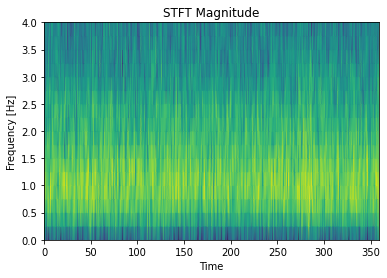

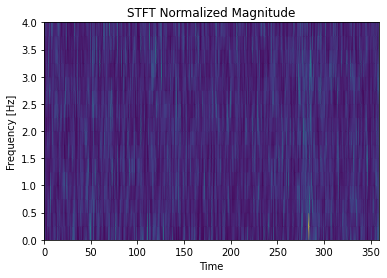

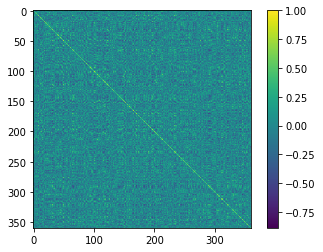

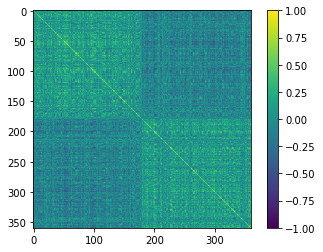

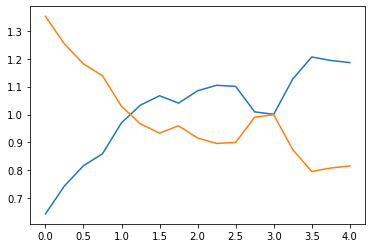

In [31]:
frequencies, spectrum = welch_psd_per_bin(data14, nperseg=80000, noverlap=40000)
print(frequencies[:17])
show_spectogram(frequencies, spectrum, nfreqs=17)
norm_freq_power = show_normalized_spectogram(frequencies, spectrum, nfreqs=17)
corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power)
ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes)
cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power, nfreqs=17)
# print(avrg_freq_per_cluster(cls1))
show_graph(avrg_freq_per_cluster(cls1), avrg_freq_per_cluster(cls2), frequencies, nfreqs=17)

In [32]:
def graph_e_row(data, nfreqs=9):
    frequencies, spectrum = welch_psd_per_bin(data)
    norm_freq_power = show_normalized_spectogram(frequencies, spectrum, no_show=True, nfreqs=nfreqs)
    corr_mat, low_freq_magnitudes = show_corr_mat(norm_freq_power, no_show=True)
    ward_clusters = show_clustered_data(corr_mat, low_freq_magnitudes, no_show=True)
    cls1, cls2 = divide_to_clusters(ward_clusters, norm_freq_power, nfreqs=nfreqs)
    low = np.arange(2)
    high = np.arange(2, 9)
    sleep_states = np.array([0.0] * norm_freq_power.shape[0])
    for i, bin in enumerate(norm_freq_power):  # 30 minutes
        low_magnitude_bin = bin[low].mean()  # average magnitude of delta frequencies in bin
        high_magnitude_bin = bin[high].mean()  # average magnitude of beta frequencies in bin
        sleep_states[i] = low_magnitude_bin / high_magnitude_bin
    return sleep_states


def show_graph_e():
    sleep_states = np.array([[0.0] * 180] * 32)
    for i in range(0, 32, 2):
        data = get_hour(int(i / 2))
        sleep_states_hour = graph_e_row(data)
        sleep_states[i] = sleep_states_hour[:180]
        sleep_states[i + 1] = sleep_states_hour[180:]
    plt.figure(figsize=(8.67, 5.33))
    plt.imshow(sleep_states, extent=[0, 30, 0, 17])
    cbar = plt.colorbar()
    cbar.set_label('low to high ratio', rotation=270)
    plt.show()
    #     plt.savefig()
    plt.close()

data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000
data.size = 72000000


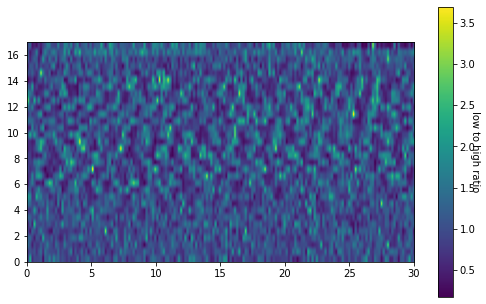

In [34]:
show_graph_e()